<a href="https://colab.research.google.com/github/Davidnet/CM3060-NLP/blob/main/CM3060NaturalLanguageProcessingSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module: CM3060 Natural Language Processing


# Introduction

## 1. Domain-Specific Area: Automated News Categorization

The global production of text news media has reached an unprecedented volume **[1]**, with thousands of sources generating content at a gigantic rate. Consequently, manually categorizing text articles is a challenging problem. An automated news categorization system can address this issue, providing a valuable tool for organizing documents. This capability can help both the public and journalists, and could even serve as a core component for custom news aggregators or even for applications in financial analysis.


---
[1] Association of Online Publishers, "Q1 2025 saw largest increase in digital publisher revenues since pandemic, AOP and Deloitte reveal," AOP, last modified June 26, 2025, https://www.ukaop.org/research/q1-2025-saw-largest-increase-in-digital-publisher-revenues-since-pandemic-aop-and-deloitte-reveal

## 2. Objectives

The aim of this project is to generate a comparative analysis between a classical statistical model and a modern deep learning model for the task of multi-class news categorization. This report will evaluate the trade-offs in predictive performance, between the two approaches. Furthermore, this project serves as an excuse for the  exploration of [Google's JAX library](https://docs.jax.dev/en/latest/quickstart.html), a high-performance framework for machine learning research. A key objective is to leverage JAX and the high level library NNX to implement and train the deep learning model, with the goal of potentially using specialized hardware like a Tensor Processing Unit (TPU) to assess the capabilities of this hardware accelerator.

## 3. Description of the Dataset
The dataset used for this project is the AG's news topic classification dataset. The original corpus is a collection of more than one million news articles gathered from over 2,000 news sources by the ComeToMyHead academic news search engine. As described in the TensorFlow Datasets catalog, this collection was assembled over more than a year of activity starting in 2004.

The final benchmark dataset was constructed by Xiang Zhang, Junbo Zhao, and Yann LeCun for their paper, "Character-level Convolutional Networks for Text Classification" (NIPS 2015) **[2]**. They created the dataset by selecting the four largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples, making it a well-balanced dataset for text classification research.

| Property | Description |
| :--- | :--- |
| **Dataset Name** | AG News (Subset) |
| **Source** | TensorFlow Datasets (`ag_news_subset`) |
| **Total Samples** | ~127,600 |
| **No. of Classes** | 4 |
| **Class Labels** | 1 (World), 2 (Sports), 3 (Business), 4 (Sci/Tech) |
| **Features** | Title and Description (Text) |

The dataset is already split in train, and test with:

| Split | Examples |
|---|---|
| 'test' | 7,600 |
| 'train' | 120,000 |

## Sample

| description | label | title |
|---|---|---|
| Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger. | 3 (Sci/Tech) | 'Halt science decline in schools' |


---
[2] Zhang, Xiang, Junbo Zhao, and Yann LeCun. "Character-level Convolutional Networks for Text Classification." Advances in Neural Information Processing Systems 28 (2015).

/usr/local/lib/python3.11/dist-packages/jax/_src/cloud_tpu_init.py:84: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


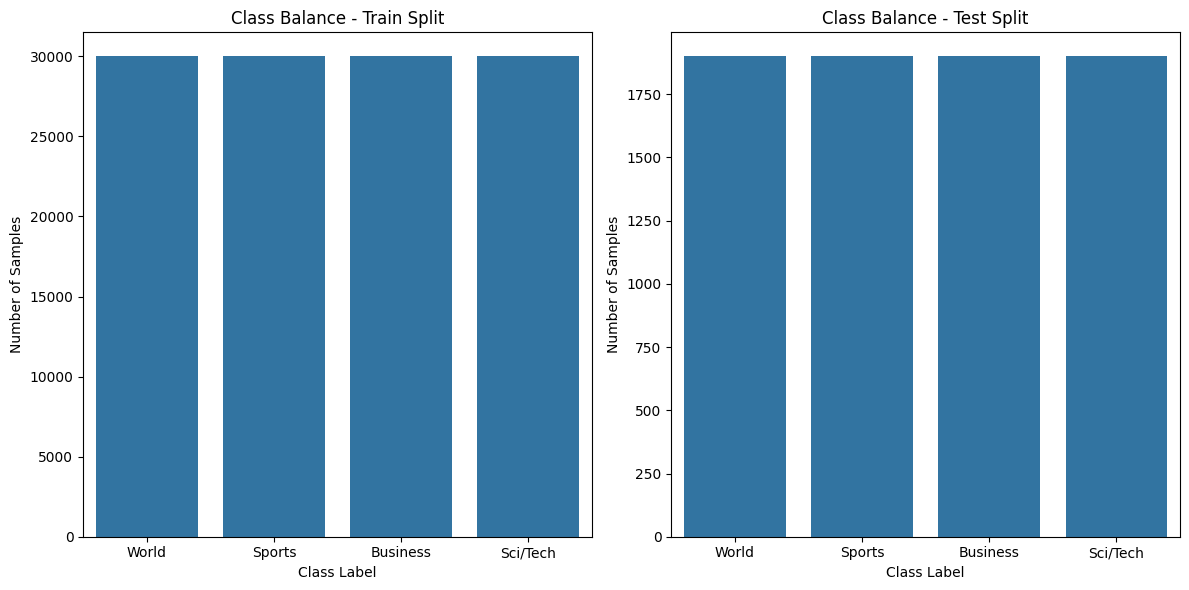

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow_datasets as tfds
# Load the ag_news_subset dataset
ds = tfds.load('ag_news_subset', as_supervised=False)

# Get class counts for train and test splits
train_counts = pd.Series([int(example['label']) for example in ds['train']]).value_counts().sort_index()
test_counts = pd.Series([int(example['label']) for example in ds['test']]).value_counts().sort_index()
counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts})

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Train Split
sns.barplot(x=counts_df.index, y='Train', data=counts_df, ax=axes[0])
axes[0].set_title('Class Balance - Train Split')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticks(counts_df.index)
axes[0].set_xticklabels(['World', 'Sports', 'Business', 'Sci/Tech'])

# Plot for Test Split
sns.barplot(x=counts_df.index, y='Test', data=counts_df, ax=axes[1])
axes[1].set_title('Class Balance - Test Split')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xticks(counts_df.index)
axes[1].set_xticklabels(['World', 'Sports', 'Business', 'Sci/Tech'])

plt.tight_layout()
plt.show()

The dataset is balanced, with an equal number of samples per class.

## 4. Evaluation Methology
The performance of both models will be evaluated using the following standard metrics for classification:

| Metric | Description | Formula |
| :--- | :--- | :--- |
| **Accuracy** | The ratio of correctly predicted instances to the total instances. It can be misleading if class distributions are imbalanced. | $$\frac{(TP + TN)}{ Total}$$ |
| **Precision** | The ability of the classifier not to label a sample as positive that is actually negative. | $$P_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}$$ |
| **Recall** | The ability of the classifier to find all the positive samples. | $$R_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}$$ |
| **F1-Score**| The weighted average of Precision and Recall, providing a single score that balances both concerns. | $$F1_c = 2 \cdot \frac{P_c \cdot R_c}{P_c + R_c}$$ |

To provide an overall performance score for the model in this multi-class classification task, the per-class metrics are averaged across all four categories. This results in a clear, aggregated measure of the model's perfomance.

# Implementation

## 5. Data Preprocessing

Two distinct data preprocessing pipelines were developed for the statistical and deep learning models. For the baseline statistical model, text was converted into numerical vectors using a TF-IDF (implementation from sklearn), which involved tokenization, stop word removal, and limiting the vocabulary to the 10,000 most frequent words.

For the deep learning model (GPT-2), a more sophisticated pipeline was implemented. The 'title' and 'description' fields from the dataset were first concatenated into a single text input. This text was then tokenized using the standard "gpt2" tokenizer from the tiktoken library**[3]**. To ensure uniform input size for the model, each tokenized sequence was either truncated or padded with the end-of-text (<|endoftext|>) token to a fixed length of 256. This entire process was integrated into a tf.data pipeline for efficient batching and processing during training.


### Model Preprocessing Comparison: Naive Bayes vs. GPT-2

### Table 1: Preprocessing Steps for Statistical and Deep Learning Models

| Preprocessing Step | Statistical Model (Naive Bayes) | Deep Learning Model (GPT-2) |
| :--- | :--- | :--- |
| **Tokenization** | Word-level, split by space/punctuation. | Sub-word, using `tiktoken` "gpt2" tokenizer. |
| **Feature Engineering**| Uses 'description' field only. | Concatenates 'title' and 'description' fields. |
| **Stop Words** | Removed using a standard list. | Retained as part of the tokenizer's vocabulary. |
| **Vectorization** | TF-IDF Vectorization (`TfidfVectorizer`). | Integer encoding from the tokenizer's vocabulary. |
| **Input Formatting** | Fixed-size TF-IDF vectors. | Padded/Truncated to a fixed sequence length of 256. |


### Rationale for Deep Learning Benefits in Preprocessing

**Tokenization**
The benefit for deep learning models lies in **semantic richness and out-of-vocabulary (OOV) handling**. Sub-word tokenization, such as Byte Pair Encoding (BPE), deconstructs rare or unseen words into familiar smaller units. For instance, "unprecedented" might become "un," "precedent," and "ed." This technique enables the model to deduce the meaning of unknown words and comprehend morphological relationships, thereby preserving more semantic information compared to basic word splitting.**[3]**

**Feature Engineering**
For **contextual understanding**, transformer models like GPT-2 are engineered to grasp the relationships and context between various segments of input text. By combining the 'title' and 'description' fields, the model learns how the title establishes the context for the description. This leads to more accurate classification than the "bag-of-words" approach, which treats words as independent features.

**Stop Words**
Deep learning models benefit from the **preservation of syntax and meaning** by retaining stop words. Words like "a," "in," "not," and "but" are crucial for understanding grammatical structure, negation, and the relationships between concepts. The attention mechanism in GPT-2 utilizes these words to construct a comprehensive understanding of a sequence's semantic meaning, which is often compromised when they are removed in traditional methods.

**Vectorization**
The advantage here comes from **contextual embeddings**. While TF-IDF generates static, context-independent vectors based on word frequency, the integer encoding used for GPT-2 serves as input to an embedding layer. This layer produces dense, context-aware vector representations (embeddings) for each token. Consequently, a word's meaning is shaped by its surrounding words, effectively capturing nuanced semantic relationships based on the core principle of context-based meaning.

**Input Formatting**
The benefit is **sequence-awareness**. Using a fixed sequence length, in conjunction with the positional encodings intrinsic to the Transformer architecture, explicitly maintains word order. This allows GPT-2 to analyze syntax, grammar, and the flow of information—critical aspects that are entirely ignored by the "bag-of-words" assumption inherent in models like Naive Bayes and its single-vector representation.

---
[3] OpenAI. 2025. tiktoken. Version 0.9.0. GitHub. https://github.com/openai/tiktoken.

### Data Preprocessing for Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
ds_train, ds_test = tfds.load('ag_news_subset', split=['train', 'test'], as_supervised=True)
print("Dataset loaded successfully.")
# 1. Load the dataset
print("Loading ag_news_subset dataset...")
# The 'description' and 'label' keys are loaded as supervised features
ds_train, ds_test = tfds.load('ag_news_subset', split=['train', 'test'], as_supervised=True)
print("Dataset loaded successfully.")

# 2. Extract text and labels
# tfds.as_numpy converts the tf.data.Dataset into an iterator of NumPy arrays.
# For text, it yields 'bytes' objects, which need to be decoded.
print("Extracting data from dataset...")
train_texts, train_labels = zip(*[(text.decode('utf-8'), label) for text, label in tfds.as_numpy(ds_train)])
test_texts, test_labels = zip(*[(text.decode('utf-8'), label) for text, label in tfds.as_numpy(ds_test)])
print(f"Loaded {len(train_texts)} training examples and {len(test_texts)} test examples.")

# 3. Vectorize the text data using TF-IDF
# TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic
# that is intended to reflect how important a word is to a document in a
# collection or corpus.
print("Vectorizing text data with TF-IDF...")
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)
print("Vectorization complete.")

Dataset loaded successfully.
Loading ag_news_subset dataset...
Dataset loaded successfully.
Extracting data from dataset...
Loaded 120000 training examples and 7600 test examples.
Vectorizing text data with TF-IDF...
Vectorization complete.


## 6. Baseline performance

**Model**: Multinomial Naive Bayes with TF-IDF features.
Justification: This model is a strong and standard baseline for text classification, representing a "bag-of-words" approach.

In [ ]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Training Multinomial Naive Bayes classifier...")
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, train_labels)
print("Training complete.")


print("Making predictions on the test set...")
y_pred = nb_classifier.predict(X_test)
print("Predictions made.")


# We are using 'macro' averaging for precision, recall, and F1-score.
print("\n--- Model Performance Metrics ---")
nb_accuracy = accuracy_score(test_labels, y_pred)
nb_precision = precision_score(test_labels, y_pred, average='macro')
nb_recall = recall_score(test_labels, y_pred, average='macro')
nb_f1 = f1_score(test_labels, y_pred, average='macro')

cm_nb = confusion_matrix(test_labels, y_pred)
cm_normalized_recall_nb = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]

print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision (Macro): {nb_precision:.4f}")
print(f"Recall (Macro): {nb_recall:.4f}")
print(f"F1-Score (Macro): {nb_f1:.4f}")
print("---------------------------------")

Training Multinomial Naive Bayes classifier...
Training complete.
Making predictions on the test set...
Predictions made.

--- Model Performance Metrics ---
Accuracy: 0.8879
Precision (Macro): 0.8875
Recall (Macro): 0.8879
F1-Score (Macro): 0.8876
---------------------------------


In [ ]:
from IPython.display import display, Markdown

markdown_content = f"""
The baseline model chosen for the project is a Multinomial Naive Bayes (MNB) classifier, implemented using scikit-learn. This classifier is highly suitable for text classification tasks involving discrete features like TF-IDF scores. After training on the TF-IDF vectors of the training data, the model achieved the following performance on the test set:

- **Accuracy**: `{nb_accuracy:.4f}`
- **Macro F1-Score**: `{nb_f1:.4f}`
- **Macro Precision**: `{nb_precision:.4f}`
- **Macro Recall**: `{nb_recall:.4f}`
"""

# Render f-string
display(Markdown(markdown_content))


The baseline model chosen for the project is a Multinomial Naive Bayes (MNB) classifier, implemented using scikit-learn. This classifier is highly suitable for text classification tasks involving discrete features like TF-IDF scores. After training on the TF-IDF vectors of the training data, the model achieved the following performance on the test set:

- **Accuracy**: `0.8879`
- **Macro F1-Score**: `0.8876`
- **Macro Precision**: `0.8875`
- **Macro Recall**: `0.8879`


## 7. Comparative Classification approach

The deep learning model is a GPT-2 architecture inspired by the educational implementation detailed by Karpathy [4]. In the spirit of that work, this project adapts its fundamental design, translating the core logic from a NumPy framework to JAX to leverage its high-performance computing capabilities.

---
[4] Andrej Karpathy, minGPT (GitHub, 2022), https://github.com/karpathy/minGPT.

### Preprocesing for GPT2

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
def get_ag_news_datasets():
    """Loads and preprocesses the AG News dataset."""
    # Load the dataset from TFDS
    ds_builder = tfds.builder('ag_news_subset')
    ds_builder.download_and_prepare()
    # Use 80% for training, 20% for validation from the 'train' split
    train_split = tfds.split_for_jax_process('train', drop_remainder=True)
    test_split = tfds.split_for_jax_process('test', drop_remainder=True)

    train_ds_raw = ds_builder.as_dataset(split=train_split, shuffle_files=True)
    test_ds_raw = ds_builder.as_dataset(split=test_split, shuffle_files=False)

    def preprocess_fn(example):
        """Tokenize text and prepare for the model."""
        # The dataset provides 'title' and 'description'. We'll combine them.
        text = tf.strings.join([example['title'], example['description']], separator=" ")
        # The tokenizer expects a Python string, so we use tf.py_function
        def _tokenize(text_tensor):
            # Decode from tensor bytes to python string
            text_py = text_tensor.numpy().decode('utf-8')
            # Tokenize and pad/truncate
            tokens = tokenizer.encode(text_py)
            if len(tokens) > seqlen:
                tokens = tokens[:seqlen]
            else:
                tokens = tokens + [tokenizer.eot_token] * (seqlen - len(tokens)) # Pad with EOT token
            return np.array(tokens, dtype=np.int32)

        # Wrap the Python function to use it in the TF dataset pipeline
        tokenized_text = tf.py_function(_tokenize, [text], tf.int32)
        tokenized_text.set_shape([seqlen])
        return tokenized_text, example['label']

    train_ds = (
          train_ds_raw
          .shuffle(10000)
          .map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(total_batch_size, drop_remainder=True)
          .prefetch(tf.data.AUTOTUNE)
      )
    test_ds = (
        test_ds_raw
        .map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(total_batch_size, drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
    )

    return train_ds, test_ds, ds_builder.info

### Model training

My objective with this project was to have an excuse to use TPU, so we are going to install a few depedencies, and libraries that will allow us to do that.
as mentioned in previous sections, we will use the tiktoken library and the `jax-ai-stack` to implement the training loops and use flax (a similar high level library similar to Keras)

In [ ]:
!pip install -Uq tiktoken tpu-info tensorflow jax-ai-stack

In [ ]:
!pip install -Uq "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax-ai-stack 2025.4.9 requires jax==0.5.3, but you have jax 0.6.2 which is incompatible.


In [ ]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]

In [ ]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax, orbax
from collections import Counter
from dataclasses import dataclass
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import numpy as np
import tiktoken, time

Altough not necesary, I created a mesh such that I could test Distributed Data
Parallelism and FSDP or Tensor Parallelism.

But this was decided to be out of the scope of the project.

In [ ]:
print("Available JAX devices:", jax.devices())
mesh = Mesh(mesh_utils.create_device_mesh((len(jax.devices()), 1)), ('batch', 'model'))
print("Device mesh created:", mesh)

Available JAX devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]
Device mesh created: Mesh('batch': 1, 'model': 1, axis_types=(Auto, Auto))


In [ ]:
# --- Tokenizer ---
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab

In [ ]:
## Hyperparameters

num_transformer_blocks = 6   # Original GPT-2 small has 12
seqlen = 256                 # Max sequence length for news articles
embed_dim = 512              # Embedding dimension
num_heads = 8                # Number of attention heads
feed_forward_dim = 4 * embed_dim
dropout_rate = 0.3
num_classes = 4              # AG News has 4 classes (World, Sports, Business, Sci/Tech)


batch_size = 32  # Batch size per device on TPU v2

total_batch_size = batch_size * jax.device_count()

# We will train for a fixed number of epochs
num_epochs = 5
init_learning_rate = 2e-5
weight_decay = 0.01

# --- JAX/Flax Data Types ---
dtype = jnp.bfloat16
param_dtype = jnp.float32

print(f"Total batch size across {jax.device_count()} devices: {total_batch_size}")

Total batch size across 1 devices: 32


In [ ]:
train_dataset, val_dataset, ds_info = get_ag_news_datasets()
steps_per_epoch = ds_info.splits['train'].num_examples // total_batch_size
max_steps = steps_per_epoch * num_epochs

print(f"Dataset loaded: {ds_info.splits['train'].num_examples} training examples, {ds_info.splits['test'].num_examples} test examples.")
print(f"Number of classes: {num_classes}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total training steps for {num_epochs} epochs: {max_steps}")

Dataset loaded: 120000 training examples, 7600 test examples.
Number of classes: 4
Steps per epoch: 3750
Total training steps for 5 epochs: 18750


---

**Total Parameters: 44,780,036**

The model is structured as follows, with parameters calculated based on an embedding dimension of 512, a vocabulary size of 50,257, and a sequence length of 256.

| Layer (Type) | Output Shape | Parameters | Description |
| :--- | :--- | :--- | :--- |
| **`embedding_layer`** (`TokenAndPositionEmbedding`) | `(batch, 256, 512)` | **25,862,656** | **Combines token and positional information.** |
| ↪ `token_emb` (`Embed`) | `(batch, 256, 512)` | 25,731,584 | Maps input token IDs to dense vectors. Param count: $50257 \times 512$. |
| ↪ `pos_emb` (`Embed`) | `(1, 256, 512)` | 131,072 | Maps each position in the sequence to a dense vector. Param count: $256 \times 512$. |
| **`dropout`** (`Dropout`) | `(batch, 256, 512)` | **0** | **Applies dropout to the embeddings during training (rate=0.1).** |
| **`transformer_blocks`** (`TransformerBlock` x6) | `(batch, 256, 512)` | **18,914,304** | **Six identical transformer blocks, forming the core of the model.** |
| &nbsp;&nbsp;&nbsp; *Per Block:* | | *3,152,384* | *Each block contains the following sub-layers:* |
| &nbsp;&nbsp;&nbsp; ↪ `layer_norm1` (`LayerNorm`) | `(batch, 256, 512)` | 1,024 | Pre-normalization for the attention layer. |
| &nbsp;&nbsp;&nbsp; ↪ `mha` (`MultiHeadAttention`) | `(batch, 256, 512)` | 1,050,624 | Multi-head self-attention with 8 heads and a head dimension of 64. |
| &nbsp;&nbsp;&nbsp; ↪ `dropout1` (`Dropout`) | `(batch, 256, 512)` | 0 | Residual dropout after the attention layer. |
| &nbsp;&nbsp;&nbsp; ↪ `layer_norm2` (`LayerNorm`) | `(batch, 256, 512)` | 1,024 | Pre-normalization for the feed-forward network. |
| &nbsp;&nbsp;&nbsp; ↪ `linear1` (`Linear`) | `(batch, 256, 2048)` | 1,050,624 | First layer of the feed-forward network (FFN). |
| &nbsp;&nbsp;&nbsp; ↪ `linear2` (`Linear`) | `(batch, 256, 512)` | 1,049,088 | Second layer of the FFN. |
| &nbsp;&nbsp;&nbsp; ↪ `dropout2` (`Dropout`) | `(batch, 256, 512)` | 0 | Residual dropout after the FFN. |
| **`layer_norm`** (`LayerNorm`) | `(batch, 512)` | **1,024** | **Final normalization applied to the last token's output.** |
| **`classifier`** (`Linear`) | `(batch, 4)` | **2,052** | **Final linear layer to produce logits for 4 classes.** |

In [ ]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float, rngs: nnx.Rngs):
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          dtype=dtype,
                                          param_dtype=param_dtype,
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=dropout_rate)  # Added dropout layer after MHA
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=dropout_rate)

    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        bs, seq_len, emb_sz = input_shape

        attention_output = self.mha(
            inputs_q=self.layer_norm1(inputs),
            mask=causal_attention_mask(seq_len),
            decode=False,
        )
        x = inputs + self.dropout1(attention_output, deterministic=not training)

        # MLP
        mlp_output = self.linear1(self.layer_norm2(x))
        mlp_output = nnx.gelu(mlp_output)
        mlp_output = self.linear2(mlp_output)
        mlp_output = self.dropout2(mlp_output, deterministic=not training)

        return x + mlp_output


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=seqlen, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return self.token_emb, token_embedding+position_embedding


class GPT2ForSequenceClassification(nnx.Module):
    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, num_heads: int, rate: float, feed_forward_dim: int, num_transformer_blocks: int, num_classes:int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    seqlen, vocab_size, embed_dim, rngs=rngs
                )
        self.dropout = nnx.Dropout(rate=rate)

        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, dropout_rate, rngs=rngs
        ) for _ in range(num_transformer_blocks)]

        self.layer_norm = nnx.LayerNorm(epsilon=1e-6,
                                    num_features=embed_dim,
                                    scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                    bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                    dtype=dtype,
                                    param_dtype=param_dtype,
                                    rngs=rngs)

        self.classifier = nnx.Linear(
            in_features=embed_dim,
            out_features=num_classes,
            kernel_init=nnx.with_partitioning(nnx.initializers.normal(stddev=0.02), NamedSharding(mesh, P(None, 'model'))),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros, NamedSharding(mesh, P('model'))),
            dtype=dtype,
            param_dtype=param_dtype,
            rngs=rngs
        )

    def __call__(self, inputs, training: bool = False):
        token_embedding, x = self.embedding_layer(inputs)
        x = self.dropout(x, deterministic=not training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)

        x = x[:, -1, :] # (batch, embed_dim)
        x = self.layer_norm(x)
        logits = self.classifier(x)

        return logits

def create_model(rngs):
    return GPT2ForSequenceClassification(seqlen, vocab_size, embed_dim, num_heads, dropout_rate, feed_forward_dim, num_transformer_blocks, num_classes=4, rngs=rngs)

We use Jax Just-in-Time compiler to improve the speed of the operations

In [ ]:
@nnx.jit
def loss_fn(model: GPT2ForSequenceClassification, batch):
    """Calculates cross-entropy loss for classification."""
    tokens, labels = batch
    logits = model(tokens)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
    return loss

@nnx.jit
def train_step(model: GPT2ForSequenceClassification, optimizer: nnx.Optimizer, batch):
    """Performs a single training step, updating model weights."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, batch)
    # Update model parameters
    optimizer.update(grads)
    return loss

@nnx.jit
def eval_step(model: GPT2ForSequenceClassification, batch):
    """
    Performs an evaluation step, returning loss, logits, and labels.
    """
    tokens, labels = batch

    # Forward pass
    # Get model predictions (logits)
    logits = model(tokens)
    # Calculate loss, e.g., cross-entropy
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
    # Return loss, logits, and the true labels for metric calculation
    return loss, logits, labels

In [ ]:
## Here we validate the number of parameters
model = create_model(rngs=nnx.Rngs(0))
p_sizes = jax.tree.map(lambda p: p.size if isinstance(p, jnp.ndarray) else 0, nnx.state(model))
import operator
print(f"Number of model parameters: {jax.tree.reduce(operator.add, p_sizes)}")

Number of model parameters: 44780036


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = create_model(rngs=nnx.Rngs(0)) # Recreate in case
schedule = optax.cosine_decay_schedule(
  init_value=init_learning_rate,
  decay_steps=max_steps
)
optax_chain = optax.chain(
  optax.adamw(learning_rate=schedule, weight_decay=weight_decay)
)
optimizer = nnx.Optimizer(model, optax_chain)

rng = jax.random.PRNGKey(0)

validation_frequency = 900
metrics_history = {
  'train_loss': [],
  'val_loss': [],
  'val_accuracy': [],
  'val_precision': [],
  'val_recall': [],
  'val_f1': []
}

total_steps = 0
start_time = time.time()
for epoch in range(num_epochs):
    # --- Training Phase ---
    epoch_train_losses = []
    for batch in tfds.as_numpy(train_dataset):
        sharded_batch = jax.device_put(batch, NamedSharding(mesh, P('batch')))
        loss = train_step(model, optimizer, sharded_batch)
        epoch_train_losses.append(loss)
        if total_steps % 720 == 0:
            print(f"Step: {total_steps}, Batch Training Loss: {loss}")
        total_steps += 1

    # Calculate average training loss for the completed epoch
    avg_train_loss = jnp.mean(jnp.array(epoch_train_losses))
    metrics_history['train_loss'].append(avg_train_loss)

    # Accumulate validation losses for this epoch
    epoch_val_losses = []
    epoch_val_losses = []
    all_labels = []
    all_predictions = []
    for val_batch in tfds.as_numpy(val_dataset):
        sharded_val_batch = jax.device_put(val_batch, NamedSharding(mesh, P('batch')))
        # eval_step should return the loss for the validation batch
        val_loss, logits, labels = eval_step(model, sharded_val_batch)
        all_predictions.append(jnp.argmax(logits, axis=-1))
        all_labels.append(labels)

        epoch_val_losses.append(val_loss)

    avg_val_loss = jnp.mean(jnp.array(epoch_val_losses))
    metrics_history['val_loss'].append(avg_val_loss)

    # Concatenate lists of batch arrays into single JAX arrays
    y_pred_jax = jnp.concatenate(all_predictions)
    y_true_jax = jnp.concatenate(all_labels)

    # Move to CPU so scikit-learn can compute metrics
    y_pred_np = np.array(y_pred_jax)
    y_true_np = np.array(y_true_jax)


    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, average='macro')
    recall = recall_score(y_true_np, y_pred_np, average='macro')
    f1 = f1_score(y_true_np, y_pred_np, average='macro')

    # Log all calculated metrics
    metrics_history['val_accuracy'].append(accuracy)
    metrics_history['val_precision'].append(precision)
    metrics_history['val_recall'].append(recall)
    metrics_history['val_f1'].append(f1)


    # Log epoch results
    epoch_time = time.time() - start_time
    print(f"\n--- Epoch {epoch+1}/{num_epochs} Summary ---")
    print(f"Time: {epoch_time:.2f}s")
    print(f"Average Training Loss: {avg_train_loss}")
    print(f"Average Validation Loss: {avg_val_loss}\n")
    start_time = time.time() # Reset timer for the next epoch

# After training is complete, metrics_history contains the results
print("Training finished.")

Step: 0, Batch Training Loss: 1.46875
Step: 720, Batch Training Loss: 0.699219
Step: 1440, Batch Training Loss: 0.503906
Step: 2160, Batch Training Loss: 0.229492
Step: 2880, Batch Training Loss: 0.371094
Step: 3600, Batch Training Loss: 0.177734

--- Epoch 1/5 Summary ---
Time: 154.06s
Average Training Loss: 0.451172
Average Validation Loss: 0.310547

Step: 4320, Batch Training Loss: 0.208984
Step: 5040, Batch Training Loss: 0.104492
Step: 5760, Batch Training Loss: 0.353516
Step: 6480, Batch Training Loss: 0.130859
Step: 7200, Batch Training Loss: 0.0869141

--- Epoch 2/5 Summary ---
Time: 113.06s
Average Training Loss: 0.212891
Average Validation Loss: 0.267578

Step: 7920, Batch Training Loss: 0.0148315
Step: 8640, Batch Training Loss: 0.118652
Step: 9360, Batch Training Loss: 0.15625
Step: 10080, Batch Training Loss: 0.106445
Step: 10800, Batch Training Loss: 0.292969

--- Epoch 3/5 Summary ---
Time: 109.31s
Average Training Loss: 0.136719
Average Validation Loss: 0.285156

Step: 

In [ ]:
ml_accuracy = metrics_history['val_accuracy'][-1]
ml_precision = metrics_history['val_precision'][-1]
ml_recall = metrics_history['val_recall'][-1]
ml_f1 = metrics_history['val_f1'][-1]


print(f"Accuracy: {ml_accuracy:.4f}")
print(f"Precision (Macro): {ml_precision:.4f}")
print(f"Recall (Macro): {ml_recall:.4f}")
print(f"F1-Score (Macro): {ml_f1:.4f}")
print("---------------------------------")

Accuracy: 0.9163
Precision (Macro): 0.9162
Recall (Macro): 0.9163
F1-Score (Macro): 0.9162
---------------------------------


In [ ]:
from IPython.display import display, Markdown

markdown_content = f"""
The GPT-2 model. After training on the BPE vectors of the training data, the model achieved the following performance on the test set:

- **Accuracy**: `{ml_accuracy:.4f}`
- **Macro F1-Score**: `{ml_f1:.4f}`
- **Macro Precision**: `{ml_precision:.4f}`
- **Macro Recall**: `{ml_recall:.4f}`
"""

# Render f-string
display(Markdown(markdown_content))


The GPT-2 model. After training on the BPE vectors of the training data, the model achieved the following performance on the test set:

- **Accuracy**: `0.9163`
- **Macro F1-Score**: `0.9162`
- **Macro Precision**: `0.9162`
- **Macro Recall**: `0.9163`


Let us look in detail the confusion matrices for both models

In [ ]:
info = tfds.builder('ag_news_subset').info
class_names = info.features['label'].names
cm_ml = confusion_matrix(y_true_np, y_pred_np)
cm_normalized_recall_ml = cm_ml.astype('float') / cm_ml.sum(axis=1)[:, np.newaxis]

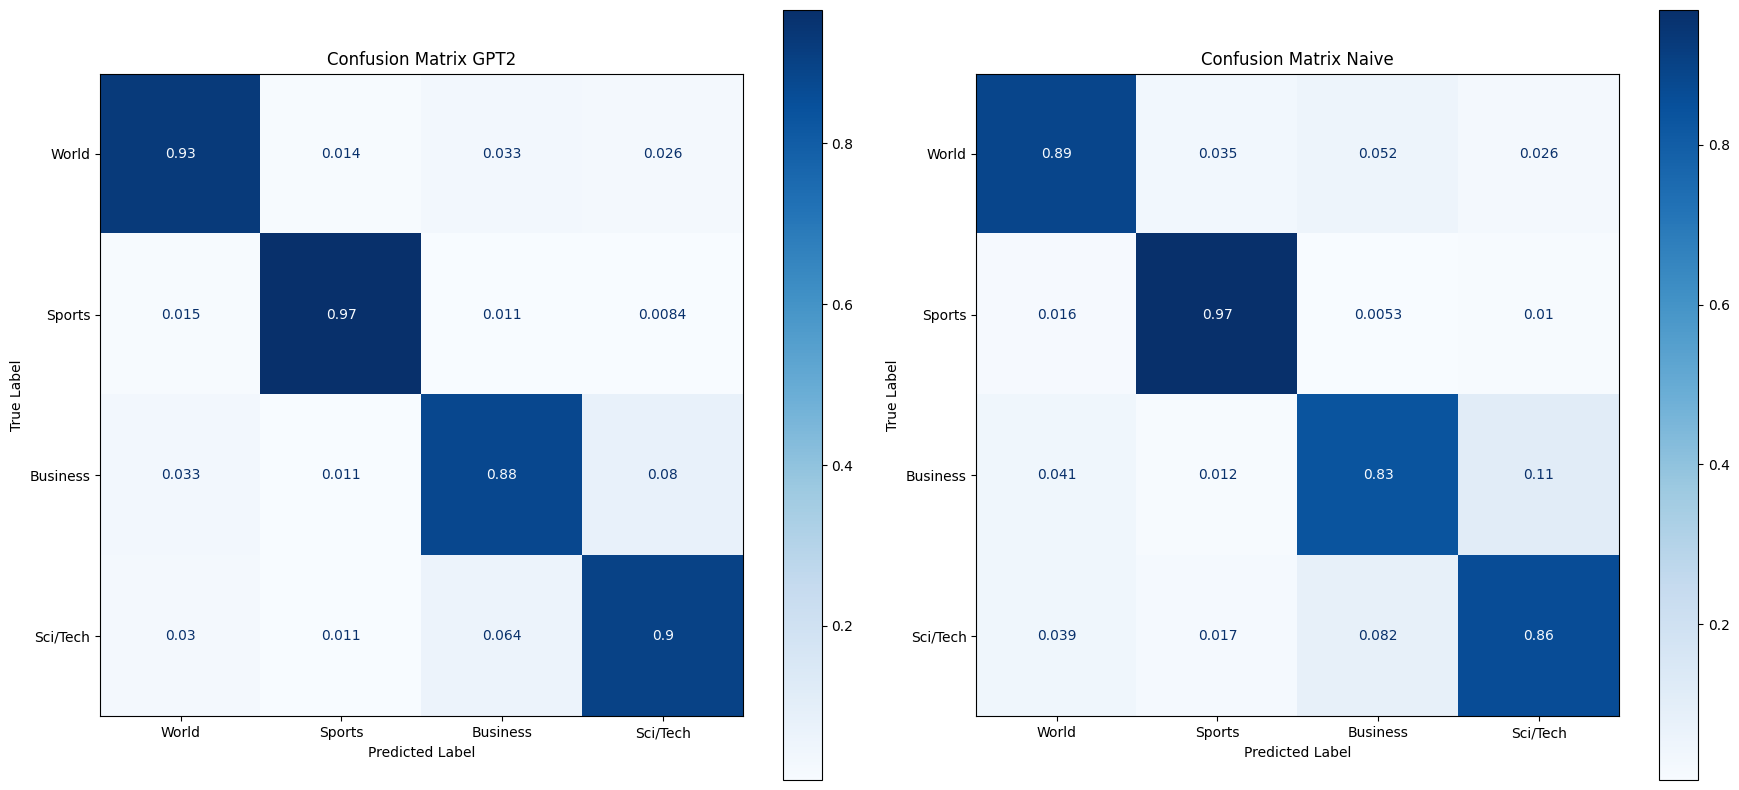

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns

# Create the first ConfusionMatrixDisplay object
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_recall_ml, display_labels=class_names)

# Plot the first confusion matrix on the first subplot (ax1)
disp1.plot(cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix GPT2')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Create the second ConfusionMatrixDisplay object
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_recall_nb, display_labels=class_names)

# Plot the second confusion matrix on the second subplot (ax2)
disp2.plot(cmap=plt.cm.Blues, ax=ax2)
ax2.set_title('Confusion Matrix Naive')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Model Saving

Even though we're using a TPU and can train a model with 44,780,036 parameters in under 6 minutes, we still want to save the model, to avoid waiting for the training cycle to finish, (we can reproduce the model since JAX is deterministic)

In [ ]:
import orbax.checkpoint as orbax
import shutil


checkpoint_path = "/content/checkpoints/midterm-model"

# make sure the folder is empty and usable
shutil.rmtree(checkpoint_path, ignore_errors=True)

checkpointer = orbax.PyTreeCheckpointer()
train_state = nnx.state(model)
checkpointer.save(checkpoint_path, train_state)

And loading the model:

In [ ]:
model = nnx.eval_shape(lambda: create_model(rngs=nnx.Rngs(0)))
state = nnx.state(model)
checkpointer = orbax.PyTreeCheckpointer()
state = checkpointer.restore(checkpoint_path, item=state)
nnx.update(model, state)

for val_batch in tfds.as_numpy(val_dataset):
        sharded_val_batch = jax.device_put(val_batch, NamedSharding(mesh, P('batch')))
        # eval_step should return the loss for the validation batch
        val_loss, logits, labels = eval_step(model, sharded_val_batch)
        print(jnp.argmax(logits, axis=-1))
        break

/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


[1 0 3 1 0 3 1 1 0 2 0 3 2 0 0 1 1 3 2 0 2 3 0 2 3 0 3 0 2 3 3 3]


# Conclusions


## 9. Performance Analysis & Comparative Discussion

The project successfully accomplished the objective of training a modern, large-scale language model using JAX. The GPT-2-based model, with approximately 45 million parameters, was trained efficiently on a TPU in under six minutes, demonstrating the high-performance capabilities of the JAX ecosystem.


| Metric | Statistical Model (Naive Bayes) | Deep Learning Model (JAX GPT-2) |
| :--- | :--- | :--- |
| Accuracy | 0.8879 | 0.9163 |
| Macro Avg Precision | 0.8875 | 0.9162 |
| Macro Avg Recall | 0.8879 | 0.9163 |
| Macro Avg F1-Score | 0.8876 | 0.9162 |
| Training Time | ~30 seconds | ~6 minutes |


As shown in the table, the JAX GPT-2 model surpasses the Naive Bayes baseline across all metrics. However, the performance gain of approximately 3-4% might initially seem modest given the vast difference in model size and complexity. This highlights a key finding: for a well-structured dataset like AG News, the marginal returns of a much larger model can be subtle when looking only at top-line metrics.

A more insightful analysis comes from the confusion matrices. While the baseline model performs well, the GPT-2 model demonstrates a superior ability to distinguish between classes. The most notable area of confusion for the advanced model is between the 'Business' and 'Sci/Tech' categories. This is an expected and understandable difficulty, as news articles in these domains often share significant thematic and overlap (e.g., a story about a tech company's quarterly earnings). The model's ability to separate these closely related topics, even if imperfectly, showcases its more nuanced understanding of the text compared to the baseline. Furthermore, the minimal evidence of overfitting, despite the model's large capacity, means that we got a correct training process with a TPU node.

# 10. Project Summary and Reflections

This project successfully conducted a comparative analysis of a classical statistical model (Multinomial Naive Bayes) and a modern deep learning model (a 45M parameter GPT-2 variant) for news classification. The results confirmed the superior performance of the deep learning approach, which achieved an F1-score of 0.9162 compared to the baseline's 0.8876. This validates the hypothesis that sequence-aware models which process contextual information provide a distinct advantage over simpler "bag-of-words" methods.

A central objective was to gain practical experience with Google's JAX library and its high-level NNX interface for training on specialized hardware. This goal was unequivocally met. The implementation of a GPT-2 model from scratch provided a deep, hands-on understanding of the Transformer architecture. Leveraging JAX's Just-In-Time (JIT) compilation on a TPU demonstrated its profound efficiency, enabling the training of a large model in under six minutes—a task that would be significantly slower on conventional hardware. This experience highlighted the power and scalability of modern ML frameworks for tackling large-scale problems.

This project underscores a crucial trade-off in machine learning: for many tasks, a simple, fast baseline can provide strong results. The additional complexity and computational cost of a deep learning model are justified when the application demands the highest possible accuracy and a more nuanced understanding of the data.

For future work, several avenues could be explored to build upon these results. Firstly, fine-tuning a pre-trained GPT-2 model, rather than training from scratch, would likely yield a significant performance boost by leveraging existing linguistic knowledge. Additionally, the current model could be further optimized through hyperparameter tuning. Finally, while the AG News dataset is substantial, training on an even larger and more diverse corpus could enhance the model's generalization capabilities and potentially improve its performance on closely related categories.
